In [1]:
import torch
from torchvision.datasets import MNIST
from torch import nn
from nn_core.common import PROJECT_ROOT

/home/don/miniconda3/envs/lf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/don/miniconda3/envs/lf/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/don/miniconda3/envs/lf/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Instantiate datasets

In [2]:
from torchvision import transforms

transf = transforms.Compose([transforms.ToTensor()])

In [4]:
train_dataset = MNIST(root=PROJECT_ROOT / "data", train=True, transform=transf, download=True)
val_dataset = MNIST(root=PROJECT_ROOT / "data", train=False, transform=transf, download=True)

100%|██████████| 9912422/9912422 [00:06<00:00, 1571930.31it/s]


Extracting /home/don/Code/latent-aggregation/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/don/Code/latent-aggregation/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1647544.29it/s]

Extracting /home/don/Code/latent-aggregation/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/don/Code/latent-aggregation/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2846598.76it/s]


Extracting /home/don/Code/latent-aggregation/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/don/Code/latent-aggregation/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1790126.74it/s]

Extracting /home/don/Code/latent-aggregation/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/don/Code/latent-aggregation/data/MNIST/raw



# Select Anchors

In [5]:
ANCHORS_NUM = 300

In [6]:
import random

idxs = list(range(len(train_dataset)))
random.shuffle(idxs)
anchors_idxs = idxs[:ANCHORS_NUM]

anchors = torch.stack([train_dataset[anchor_idx][0] for anchor_idx in anchors_idxs])

## Define Model


In [7]:
class NaiveCNN(nn.Module):
    def __init__(self, hidden_size: int = 128, in_channels: int = 1, num_classes: int = 10):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        self.encoding = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.SiLU(),
            nn.MaxPool2d(2),
        )
        fake_out = self.encoding(torch.randn(2, 1, 28, 28)).view(2, -1).shape[-1]
        self.encoding_proj = nn.Linear(fake_out, hidden_size)

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout(0.25),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, num_classes),
        )

    def forward(self, x, return_embeddings: bool = False):
        embedding = self.encoding(x)
        embedding = embedding.view(x.shape[0], -1)
        embedding = self.encoding_proj(embedding)

        if return_embeddings:
            return embedding

        logits = self.decoder(embedding)
        return logits

# Train function


In [12]:
from torch.optim import Adam
from tqdm import tqdm
from pytorch_lightning import seed_everything
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics import Accuracy
import matplotlib.pyplot as plt


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def plot_history(history, keys="train_acc"):
    if isinstance(keys, str):
        keys = [keys]
    fig, ax = plt.subplots(1, 1)
    for key in keys:
        ax.scatter(x=history["global_step"], y=history[key], label=key)
    ax.legend()
    return fig


def validate(model, val_dataset=val_dataset, device=DEVICE):
    val_acc = Accuracy().to(device)

    val_dl = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=1)
    model = model.to(device).eval()
    for images, gt_y in val_dl:
        images = images.to(device, non_blocking=True)
        gt_y = gt_y.to(device, non_blocking=True)
        pred_y = model(images)
        val_acc(pred_y, gt_y)

    model = model.eval().cpu()

    return val_acc.compute().cpu().item()


def train(
    model: nn.Module,
    train_dataset: Dataset,
    perc_subsamples_dataset: float,
    val_dataset: Dataset,
    lr: float = 0.001,
    epochs: int = 50,
    batch_size=512,
    seed: int = 0,
    device: str = DEVICE,
    loss_freq=50,
):
    seed_everything(seed)

    train_dataset, _ = random_split(train_dataset, [perc_subsamples_dataset, 1 - perc_subsamples_dataset])
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
    val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

    model = model.to(device)
    opt = Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_acc = Accuracy().to(device)
    val_acc = Accuracy().to(device)
    history = {key: [] for key in ["loss", "global_step", "train_acc"]}
    global_step = 0
    for epoch in (tqdm_bar := tqdm(range(epochs), leave=False, desc="epoch")):
        for images, gt_y in train_dl:
            images = images.to(device, non_blocking=True)
            gt_y = gt_y.to(device, non_blocking=True)
            pred_y = model(images)
            loss = loss_fn(pred_y, gt_y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_acc(pred_y, gt_y)

            history["loss"].append(loss.cpu().item())
            history["global_step"].append(global_step)
            history["train_acc"].append(train_acc.compute().cpu().item())
            global_step += 1

        tqdm_bar.set_description(f"loss: {loss:2f} ~ acc: {train_acc.compute().cpu().item():2f}")
        train_acc.reset()
    model = model.eval()

    for images, gt_y in val_dl:
        images = images.to(device, non_blocking=True)
        gt_y = gt_y.to(device, non_blocking=True)
        pred_y = model(images)
        val_acc(pred_y, gt_y)

    model = model.eval().cpu()

    print("val acc", val_acc.compute().cpu().item())

    return model, loss.cpu().item(), val_acc.compute().cpu().item(), history

# Train Reference Model

In [11]:
ref_model, ref_loss, ref_val_acc, ref_history = train(
    NaiveCNN(), train_dataset=train_dataset, perc_subsamples_dataset=1, val_dataset=val_dataset, epochs=20, lr=1e-5
)

Global seed set to 0
/home/don/miniconda3/envs/lf/lib/python3.9/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


val acc 0.9710999727249146


# Train in low data setting

In [13]:
performance = {key: [] for key in ["exp", "relsup", "perc_train", "hidden_dim", "val_acc", "epochs"]}

Global seed set to 0


val acc 0.48249998688697815


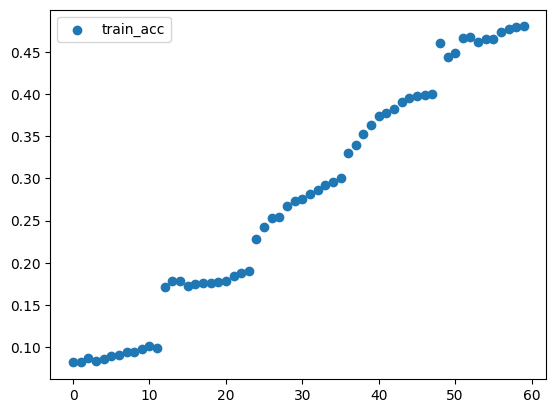

In [14]:
low_data_model, low_data_loss, low_data_val_acc, low_data_history = train(
    NaiveCNN(), train_dataset=train_dataset, perc_subsamples_dataset=0.1, val_dataset=val_dataset, epochs=5, lr=1e-5
)

_ = plot_history(low_data_history)

In [15]:
import numpy as np
from itertools import chain

for perc_train in chain(np.arange(0.01, 0.11, 0.01), np.arange(0.1, 1.01, 0.1)):
    model, loss, val_acc, history = train(
        NaiveCNN(hidden_size=128),
        train_dataset=train_dataset,
        perc_subsamples_dataset=perc_train,
        val_dataset=val_dataset,
        epochs=5,
        lr=1e-5,
    )

    performance["exp"].append("lowdata")
    performance["relsup"].append(False)
    performance["perc_train"].append(perc_train.item())
    performance["hidden_dim"].append(128)
    performance["val_acc"].append(val_acc)
    performance["epochs"].append(5)

Global seed set to 0
Global seed set to 0                                                         


val acc 0.08990000188350677


Global seed set to 0                                                         


val acc 0.09560000151395798


Global seed set to 0                                                         


val acc 0.11429999768733978


Global seed set to 0                                                         


val acc 0.14249999821186066


Global seed set to 0                                                         


val acc 0.16670000553131104


Global seed set to 0                                                         


val acc 0.20649999380111694


Global seed set to 0                                                         


val acc 0.2962000072002411


Global seed set to 0                                                         


val acc 0.38920000195503235


Global seed set to 0                                                         


val acc 0.46860000491142273


Global seed set to 0                                                         


val acc 0.5353999733924866


Global seed set to 0                                                         


val acc 0.5350000262260437


Global seed set to 0                                                         


val acc 0.7663999795913696


Global seed set to 0                                                         


val acc 0.8220000267028809


Global seed set to 0                                                         


val acc 0.8522999882698059


Global seed set to 0                                                         


val acc 0.8723999857902527


Global seed set to 0                                                         


val acc 0.8853999972343445


Global seed set to 0                                                         


val acc 0.8966000080108643


Global seed set to 0                                                         


val acc 0.9042999744415283


Global seed set to 0                                                         


val acc 0.9110000133514404


val acc 0.9164000153541565


# Relative supervision

In [16]:
from itertools import chain
import torch.nn.functional as F


def relative_projection(x, anchors):
    x = F.normalize(x, p=2, dim=-1)
    anchors = F.normalize(anchors, p=2, dim=-1)
    return torch.einsum("bm, am -> ba", x, anchors)


def relative_supervision(model, ref_model, x, anchors):
    ref_model.eval()
    latents = model(x, return_embeddings=True)

    with torch.no_grad():
        anchors_latents = model(anchors, return_embeddings=True)

        ref_latents = ref_model(x, return_embeddings=True)
        ref_anchors_latents = ref_model(anchors, return_embeddings=True)
        ref_rel_latents = relative_projection(x=ref_latents, anchors=ref_anchors_latents)

    rel_latents = relative_projection(x=latents, anchors=anchors_latents)

    # return F.cosine_embedding_loss(rel_latents, ref_rel_latents, target=torch.tensor([1.0], device=rel_latents.device))
    return F.mse_loss(
        rel_latents,
        ref_rel_latents,
    )


def calculate_adaptive_weight(loss_a: torch.Tensor, loss_b: torch.Tensor, last_layer) -> float:
    """Compute the re-scaling factor to apply to loss_b to be comparable with loss_a

    Args:
        loss_a: first loss
        loss_b: second loss
        last_layer: consider the gradients in this layer

    Returns:
        the scaling factor to apply to loss_b
    """
    try:
        loss_a_grads = torch.autograd.grad(loss_a, last_layer, retain_graph=True)[0]
        loss_b_grads = torch.autograd.grad(loss_b, last_layer, retain_graph=True)[0]

        loss_b_weight = torch.norm(loss_a_grads) / (torch.norm(loss_b_grads) + 1e-4)
        loss_b_weight = torch.clamp(loss_b_weight, 0.0, 1e6).detach()
    except RuntimeError:
        print("ERROR")
        loss_b_weight = torch.tensor(0.0)
    return loss_b_weight


def train_relative_supervision(
    model: nn.Module,
    reference_model: nn.Module,
    reference_weight: float,
    train_dataset: Dataset,
    perc_subsamples_dataset: float,
    val_dataset: Dataset,
    lr: float = 0.001,
    epochs: int = 50,
    batch_size=512,
    seed: int = 0,
    device: str = "cuda",
    loss_freq=50,
):
    global anchors

    seed_everything(seed)

    train_dataset, _ = random_split(train_dataset, [perc_subsamples_dataset, 1 - perc_subsamples_dataset])
    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=1)
    val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=1)

    model = model.to(device)
    anchors = anchors.to(device)
    reference_model = reference_model.eval().to(device)
    opt = Adam(model.parameters(), lr=lr)
    opt_enc = Adam(chain(model.encoding.parameters(), model.encoding_proj.parameters()), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_acc = Accuracy().to(device)
    val_acc = Accuracy().to(device)
    history = {key: [] for key in ["loss", "global_step", "train_acc", "class_loss", "relative_sup_loss"]}
    global_step = 0
    for epoch in (tqdm_bar := tqdm(range(epochs), leave=False, desc="epoch")):
        for images, gt_y in train_dl:
            images = images.to(device, non_blocking=True)
            gt_y = gt_y.to(device, non_blocking=True)

            relative_sup_loss = relative_supervision(model, ref_model=reference_model, x=images, anchors=anchors)
            loss = relative_sup_loss
            loss.backward()
            opt_enc.step()
            opt_enc.zero_grad()

            # b_weight = calculate_adaptive_weight(loss_a=class_loss, loss_b=relative_sup_loss, last_layer=model.encoding_proj.weight )
            # relative_sup_loss = relative_sup_loss * b_weight

            # class_loss =  class_loss# * (1 - reference_weight)
            # relative_sup_loss = relative_sup_loss * reference_weight
            pred_y = model(images)
            class_loss = loss_fn(pred_y, gt_y)
            loss = class_loss

            loss.backward()
            opt.step()
            opt.zero_grad()
            train_acc(pred_y, gt_y)

            # b_weight = calculate_adaptive_weight(loss_a=class_loss, loss_b=relative_sup_loss, last_layer=model.encoding_proj.weight )

            history["loss"].append(loss.cpu().item())
            history["class_loss"].append(class_loss.cpu().item())
            history["relative_sup_loss"].append(relative_sup_loss.cpu().item())
            history["global_step"].append(global_step)
            history["train_acc"].append(train_acc.compute().cpu().item())
            global_step += 1

        tqdm_bar.set_description(f"loss: {loss:2f} ~ acc: {train_acc.compute().cpu().item():2f}")
        train_acc.reset()
    model = model.eval()

    for images, gt_y in val_dl:
        images = images.to(device, non_blocking=True)
        gt_y = gt_y.to(device, non_blocking=True)
        pred_y = model(images)
        val_acc(pred_y, gt_y)

    model = model.eval().cpu()
    reference_model.cpu()
    print("end of training val acc", val_acc.compute().cpu().item())

    return model, loss.cpu().item(), val_acc.compute().cpu().item(), history

Global seed set to 0


end of training val acc 0.5117999911308289
ref_model 0.9710999727249146
low_data_model 0.48249998688697815
low_data_relsup_model 0.5117999911308289


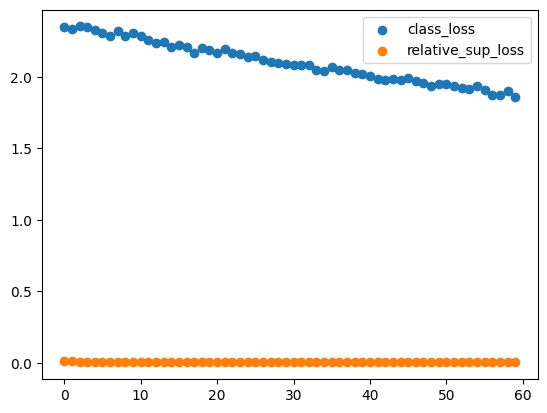

In [17]:
(
    low_data_relsup_model,
    low_data_relsup_loss,
    low_data_relsup_val_acc,
    low_data_relsup_history,
) = train_relative_supervision(
    NaiveCNN(),
    reference_model=ref_model,
    reference_weight=2,
    train_dataset=train_dataset,
    perc_subsamples_dataset=0.1,
    val_dataset=val_dataset,
    epochs=5,
    lr=1e-5,
)

print("ref_model", validate(ref_model))
print("low_data_model", validate(low_data_model))
print("low_data_relsup_model", validate(low_data_relsup_model))
_ = plot_history(low_data_relsup_history, ["class_loss", "relative_sup_loss"])

In [18]:
import numpy as np

for perc_train in chain(np.arange(0.01, 0.11, 0.01), np.arange(0.1, 1.01, 0.1)):
    model, loss, val_acc, history = train_relative_supervision(
        NaiveCNN(hidden_size=128),
        reference_model=ref_model,
        reference_weight=2,
        train_dataset=train_dataset,
        perc_subsamples_dataset=perc_train,
        val_dataset=val_dataset,
        epochs=5,
        lr=1e-5,
    )

    performance["exp"].append("lowdata")
    performance["relsup"].append(True)
    performance["perc_train"].append(perc_train.item())
    performance["hidden_dim"].append(128)
    performance["val_acc"].append(val_acc)
    performance["epochs"].append(5)

Global seed set to 0
Global seed set to 0                                                         


end of training val acc 0.09790000319480896


Global seed set to 0                                                         


end of training val acc 0.09700000286102295


Global seed set to 0                                                         


end of training val acc 0.12439999729394913


Global seed set to 0                                                         


end of training val acc 0.14669999480247498


Global seed set to 0                                                         


end of training val acc 0.16329999268054962


Global seed set to 0                                                         


end of training val acc 0.19949999451637268


Global seed set to 0                                                         


end of training val acc 0.2669999897480011


Global seed set to 0                                                         


end of training val acc 0.35019999742507935


Global seed set to 0                                                         


end of training val acc 0.4357999861240387


Global seed set to 0                                                         


end of training val acc 0.511900007724762


Global seed set to 0                                                         


end of training val acc 0.5115000009536743


Global seed set to 0                                                         


end of training val acc 0.7814000248908997


Global seed set to 0                                                         


end of training val acc 0.8367999792098999


Global seed set to 0                                                         


end of training val acc 0.8628000020980835


Global seed set to 0                                                         


end of training val acc 0.8815000057220459


Global seed set to 0                                                         


end of training val acc 0.8920999765396118


Global seed set to 0                                                         


end of training val acc 0.9024999737739563


Global seed set to 0                                                         


end of training val acc 0.9092000126838684


Global seed set to 0                                                         


end of training val acc 0.9165999889373779


end of training val acc 0.9228000044822693


# Train with smaller models


Global seed set to 0


val acc 0.6751000285148621


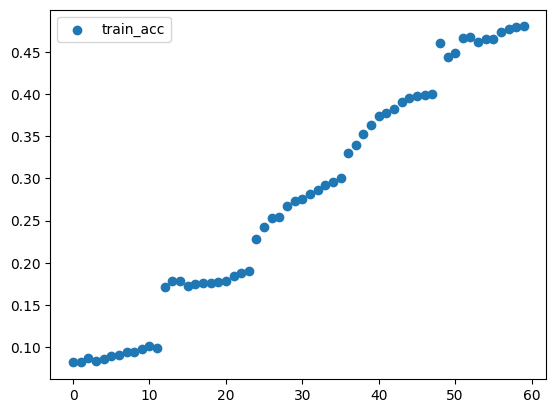

In [19]:
small_model_model, small_model_loss, small_model_val_acc, small_model_history = train(
    NaiveCNN(hidden_size=16),
    train_dataset=train_dataset,
    perc_subsamples_dataset=1,
    val_dataset=val_dataset,
    epochs=5,
    lr=1e-5,
)

_ = plot_history(low_data_history)

In [20]:
set(performance["exp"])

{'lowdata'}

In [21]:
import numpy as np

for hidden_size in chain(np.arange(2, 8, 1), np.arange(8, 128, 8)):
    model, loss, val_acc, history = train(
        NaiveCNN(hidden_size=hidden_size),
        train_dataset=train_dataset,
        perc_subsamples_dataset=1.0,
        val_dataset=val_dataset,
        epochs=5,
        lr=1e-5,
    )

    performance["exp"].append("smallmodel")
    performance["relsup"].append(False)
    performance["perc_train"].append(1.0)
    performance["hidden_dim"].append(hidden_size.item())
    performance["val_acc"].append(val_acc)
    performance["epochs"].append(5)

Global seed set to 0
Global seed set to 0                                                         


val acc 0.11599999666213989


Global seed set to 0                                                         


val acc 0.1907999962568283


Global seed set to 0                                                         


val acc 0.18310000002384186


Global seed set to 0                                                         


val acc 0.35350000858306885


Global seed set to 0                                                         


val acc 0.3352000117301941


Global seed set to 0                                                         


val acc 0.30559998750686646


Global seed set to 0                                                         


val acc 0.5343000292778015


Global seed set to 0                                                         


val acc 0.6751000285148621


Global seed set to 0                                                         


val acc 0.7519999742507935


Global seed set to 0                                                         


val acc 0.8288000226020813


Global seed set to 0                                                         


val acc 0.8499000072479248


Global seed set to 0                                                         


val acc 0.8317000269889832


Global seed set to 0                                                         


val acc 0.8675000071525574


Global seed set to 0                                                         


val acc 0.8952000141143799


Global seed set to 0                                                         


val acc 0.8878999948501587


Global seed set to 0                                                         


val acc 0.9002000093460083


Global seed set to 0                                                         


val acc 0.9104999899864197


Global seed set to 0                                                         


val acc 0.9075999855995178


Global seed set to 0                                                         


val acc 0.9085000157356262


Global seed set to 0                                                         


val acc 0.9178000092506409


val acc 0.9086999893188477


# Train with relative sup small models


Global seed set to 0


end of training val acc 0.6779000163078308
ref_model 0.9710999727249146
small_model_model 0.6751000285148621
small_model_relsup_model 0.6779000163078308


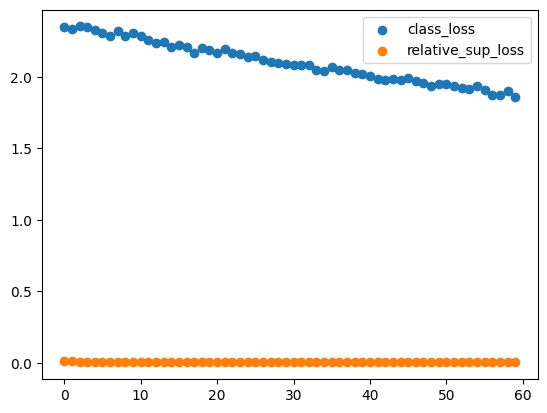

In [22]:
(
    small_model_relsup_model,
    small_model_relsup_loss,
    small_model_relsup_val_acc,
    small_model_relsup_history,
) = train_relative_supervision(
    NaiveCNN(hidden_size=16),
    reference_model=ref_model,
    reference_weight=2,
    train_dataset=train_dataset,
    perc_subsamples_dataset=1,
    val_dataset=val_dataset,
    epochs=5,
    lr=1e-5,
)

print("ref_model", validate(ref_model))
print("small_model_model", validate(small_model_model))
print("small_model_relsup_model", validate(small_model_relsup_model))
_ = plot_history(low_data_relsup_history, ["class_loss", "relative_sup_loss"])

In [23]:
import numpy as np

for hidden_size in chain(np.arange(2, 8, 1), np.arange(8, 128, 8)):
    model, loss, val_acc, history = train_relative_supervision(
        NaiveCNN(hidden_size=hidden_size),
        reference_model=ref_model,
        reference_weight=2,
        train_dataset=train_dataset,
        perc_subsamples_dataset=1,
        val_dataset=val_dataset,
        epochs=5,
        lr=1e-5,
    )

    performance["exp"].append("smallmodel")
    performance["relsup"].append(True)
    performance["perc_train"].append(1.0)
    performance["hidden_dim"].append(hidden_size.item())
    performance["val_acc"].append(val_acc)
    performance["epochs"].append(5)

Global seed set to 0
Global seed set to 0                                                         


end of training val acc 0.10949999839067459


Global seed set to 0                                                         


end of training val acc 0.19009999930858612


Global seed set to 0                                                         


end of training val acc 0.164900004863739


Global seed set to 0                                                         


end of training val acc 0.3589000105857849


Global seed set to 0                                                         


end of training val acc 0.3386000096797943


Global seed set to 0                                                         


end of training val acc 0.26840001344680786


Global seed set to 0                                                         


end of training val acc 0.47290000319480896


Global seed set to 0                                                         


end of training val acc 0.6777999997138977


Global seed set to 0                                                         


end of training val acc 0.7523999810218811


Global seed set to 0                                                         


end of training val acc 0.8259000182151794


loss: 1.857963 ~ acc: 0.329433:  20%|██        | 1/5 [00:07<00:28,  7.06s/it]

In [ ]:
import pandas as pd

In [ ]:
perf = pd.DataFrame(performance)

lowdata = perf[perf["exp"] == "lowdata"][~perf["relsup"]]
lowdata_relsup = perf[perf["exp"] == "lowdata"][perf["relsup"]]

smallmodel = perf[perf["exp"] == "smallmodel"][~perf["relsup"]]
smallmodel_relsup = perf[perf["exp"] == "smallmodel"][perf["relsup"]]
smallmodel_relsup

In [ ]:
perf.to_csv("perf.tsv", sep="\t")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x=lowdata.perc_train, y=lowdata.val_acc, label="Standard")
ax1.scatter(x=lowdata_relsup.perc_train, y=lowdata_relsup.val_acc, label="RelSup")
ax1.set_xlabel("Train dataset percentage")
ax1.set_ylabel("Validation accuracy")
ax1.legend()

ax2.scatter(x=smallmodel.hidden_dim, y=smallmodel.val_acc, label="Standard")
ax2.scatter(x=smallmodel_relsup.hidden_dim, y=smallmodel_relsup.val_acc, label="RelSup")
ax2.set_xlabel("Latent space size")
ax2.set_ylabel("Validation accuracy")
ax2.legend()